In [18]:
# importing libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import inflect
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import graphviz
import pydotplus
from IPython.display import Image
from scipy.sparse import csr_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import time
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns


In [19]:
# functions



# modified stop words so that they are without punctuation
def create_my_stop_words():
    my_stop_words = []       # stop words without punctuation
    for word in stopwords.words("english"): 
        my_word = ""
        for char in word:
            if char not in string.punctuation:
                my_word += char
        my_stop_words.append(my_word)

    other_not_included = ["hed", "itd", "theyd", "youd", "me"] # shed, wed, id are common words but he had, it had, they had, you had
    for word in other_not_included:
        my_stop_words.append(word)
    return my_stop_words


# plural word -> singular word
def singularize_word(word):
    p = inflect.engine()
    singular_word = p.singular_noun(word)
    if singular_word:
        return singular_word
    else:
        return word
    

# prepare dataset
def prepare_kaggle_dataset(df):
    df.fillna("", inplace=True) # filling empty fields
    df["combined"] = df[['Top1', "Top2", "Top3", 'Top4', 'Top5', 'Top6', 'Top7',
      'Top8', 'Top9', 'Top10', 'Top11', 'Top12', 'Top13', 'Top14', 'Top15',
      'Top16', 'Top17', 'Top18', 'Top19', 'Top20', 'Top21', 'Top22', 'Top23',
       'Top24', 'Top25']].apply(lambda row: " ".join(row), axis=1) # combining all columns into one
    
    new_df = pd.DataFrame(data={"combined": df["combined"], "label": df["Label"]})
    
    return new_df


#test = 0

# text cleaning 
def text_cleanning(row):
    global test
    remove_b = row.replace("b\"", "").replace("b'", "")   # removing b" and b'
    remove_punc = "".join([char for char in remove_b if char not in string.punctuation])     # removing punctuation !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    remove_stop_words = [word for word in remove_punc.split() if word.lower() not in my_stop_words]  # removing stopwords
    


    # comparing different techniques for removing suffixis
    """
    for i in remove_stop_words:
        print(i, " : ", porter_stemmer.stem(i, to_lowercase=False), " : ", lemmatizer.lemmatize(i), " : ", singularize_word(i))
    """
    
    lem_words = [lemmatizer.lemmatize(word) for word in remove_stop_words] # base of the words

    singular_words = [singularize_word(word) for word in lem_words]         # plural -> singular
    #if "me" in singular_words or "Me" in singular_words:
     #   test += 1

    return " ".join(singular_words)  # returning cleaned row as a string


# get each word in Count Vectorizer with its count in 0, 1 and total
def get_word_counts():
    feature_names = tokenizer.get_feature_names_out()

    # Get the indices of the "0" and "1" texts in the DataFrame
    indices_0 = df[df["label"] == 0].index
    indices_1 = df[df["label"] == 1].index

    # Get the occurrences of each word in the "0" texts
    word_counts_0 = tokenized_words[indices_0].sum(axis=0)

    # Get the occurrences of each word in the "1" texts
    word_counts_1 = tokenized_words[indices_1].sum(axis=0)

    # Create a dictionary to store the word counts
    word_counts = {
        "word": feature_names,
        "count_0": word_counts_0.tolist()[0],
        "count_1": word_counts_1.tolist()[0],
    }
    

    # Create a DataFrame from the word counts dictionary
    word_counts_df = pd.DataFrame(word_counts)
    word_counts_df["count"] = word_counts_df["count_0"] + word_counts_df["count_1"]

    return word_counts_df


# printing the prob table
def print_probabilities():
    feature_log_probs = model.feature_log_prob_

    # Convert feature log probabilities to probabilities
    feature_probs = np.exp(feature_log_probs)

    sorted_vocabulary = sorted(tokenizer.vocabulary_.items(), key=lambda x: x[1])

    vocab_arr = [item[0] for item in sorted_vocabulary]

    # Create a DataFrame to represent the probabilistic table
    prob_table = pd.DataFrame(feature_probs, columns=vocab_arr)

    word_counts_df = get_word_counts()  # getting the counts
    word_counts_df.set_index("word", inplace=True)  # making the word column index so it will match the prob_table
    
    prob_table = prob_table.transpose().sort_index()
    prob_table["count"] = word_counts_df["count"]
    prob_table["count_0"] = word_counts_df["count_0"]
    prob_table["count_1"] = word_counts_df["count_1"]
    
    
    #for_csv = prob_table.reset_index()   # adding indexes back
    #for_csv.to_csv("words_for_analysis.csv")
    
    # probability ratio
    prob_table["prob_ratio"] =  prob_table.iloc[:,1] / prob_table.iloc[:, 0]
    
    # product of prob_ratio and count
    prob_table["product_ratio_count"] = prob_table["count"] * prob_table["prob_ratio"]

    # priting the dataframe to a txt file
    with open("output.txt", "w") as f:
        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        pd.set_option('display.expand_frame_repr', False)
        #pd.set_option('display.max_colwidth', -1) 

        #print(prob_table.sort_values("pomer",  ascending=False), file=f) # sort by biggest impact on 0
        print(prob_table.sort_values("product_ratio_count", ascending=False), file=f)
        

        pd.reset_option('all')
        

# checking the performance
def my_confusion_matrix(data, predicted_col, true_col, up="up", down="down"):
    tp = data.loc[(data[predicted_col] == up) & (data[true_col] == up)]
    fp = data.loc[(data[predicted_col] == up) & (data[true_col] == down)]
    fn = data.loc[(data[predicted_col] == down) & (data[true_col] == up)]
    tn = data.loc[(data[predicted_col] == down) & (data[true_col] == down)]

    df = pd.DataFrame({"Actual up":[len(tp), len(fn)], "Actual Down":[len(fp), len(tn)]}, index=["Predicted up", "Predicted down"])

    performance = (len(tp) + len(tn)) / (len(tp) + len(tn) + len(fp) + len(fn))
    accuracyP = (len(tp) / (len(tp) + len(fp)))
    
    balance = 0.5*( (len(tp)/(len(tp)+len(fn))) + (len(tn)/(len(tn) + len(fp))))
    

    if (len(tn) + len(fn)) == 0:
        accuracyN = "no negatives predicted"
    else:
        accuracyN = (len(tn) / (len(tn) + len(fn)))
        
    return [balance, len(tp), len(fp), len(fn), len(tn)]

    


In [20]:
lemmatizer = WordNetLemmatizer()

my_stop_words = create_my_stop_words()

# load kaggle data
df = pd.read_csv("Combined_News_DJIA.csv")
df = prepare_kaggle_dataset(df)

# load news category data
#df_2 = pd.read_csv("news_category_data.csv")

# concatenate
#df = pd.concat([df, df_2], ignore_index=True)


# testing
#df = df.head(100)

df["combined"] = df['combined'].apply(text_cleanning)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df["combined"], df["label"], test_size=0.2,shuffle=True, random_state=42)

print(X_train.shape)

tokenizer = CountVectorizer(analyzer="word", lowercase=False, ngram_range=(1,1))

estimator = DecisionTreeClassifier(random_state=42)

pipeline = Pipeline([
    ("tokenizer", tokenizer),
    ("estimator", estimator)
])

param_grid = {
    "tokenizer__min_df": [25],
    #"custom__min_df": [i for i in range(10)],
    "estimator__max_depth": [i for i in range(1, 50)],
    "estimator__min_samples_leaf": [i for i in range(1, 20)]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring="balanced_accuracy")

start_time = time.time()

grid_search.fit(X_train, y_train)

end_time = time.time()

fitting_time = end_time - start_time

print(fitting_time)

(1591,)
303.63138723373413


In [28]:
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

predict = best_model.predict(X_test)
conf = pd.DataFrame({"Predicted": predict, "Actual":y_test})
print(my_confusion_matrix(conf, "Predicted", "Actual", up=1, down=0))

{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 3, 'tokenizer__min_df': 25}
[0.5043924053893912, 152, 113, 75, 58]


['tokenizer__min_df', 'estimator__max_depth', 'estimator__min_samples_leaf']


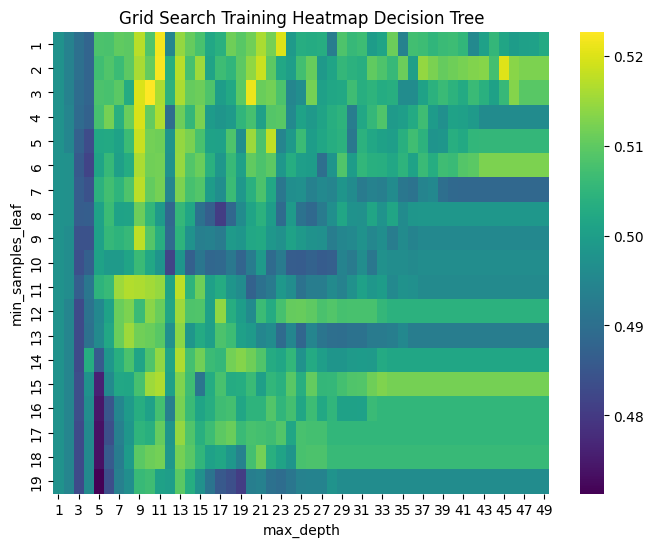

In [29]:
results = grid_search.cv_results_

#print(results)

param_grid_keys = list(param_grid.keys())
print(param_grid_keys)
param_values = [results[f'param_{key}'] for key in param_grid_keys]


mean_test_scores = results['mean_test_score']
results_df = pd.DataFrame({'min_samples_leaf': param_values[1], 'max_depth': param_values[2], 'Mean_Test_Score': mean_test_scores})

heatmap_data = results_df.pivot(index='max_depth', columns='min_samples_leaf', values='Mean_Test_Score')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', fmt='.3f', cbar=True)
plt.title('Grid Search Training Heatmap Decision Tree')
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')
plt.show()